In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv

from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from tqdm import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_columns', None)
%matplotlib inline

In [6]:
client = pd.read_csv('data/x5-uplift-valid/data/clients2.csv')

In [7]:
products = pd.read_csv('data/x5-uplift-valid/data/products.csv')

In [8]:
train_purch = pd.read_csv('data/x5-uplift-valid/train_purch/train_purch.csv')
test_purch = pd.read_csv('data/x5-uplift-valid/test_purch/test_purch.csv')

In [9]:
train_purch.head()

,client_id,transaction_id,transaction_datetime,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,store_id,product_id,product_quantity,trn_sum_from_iss,trn_sum_from_red
0,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,9a80204f78,2.0,80.0,NaN
1,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,da89ebd374,1.0,65.0,NaN
2,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,0a95e1151d,1.0,24.0,NaN
3,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,4055b15e4a,2.0,50.0,NaN
4,000012768d,7e3e2e3984,2018-12-01 07:12:45,10.0,0.0,0.0,0.0,1007.0,54a4a11a29,a685f1916b,1.0,22.0,NaN


## EDA

### Client

In [10]:
client.head()

,client_id,client_id.1,first_issue_date,first_redeem_date,age,gender
0,000012768d,NaN,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U
1,000036f903,NaN,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F
2,00010925a5,NaN,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U
3,0001f552b0,NaN,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F
4,00020e7b18,NaN,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U


In [11]:
client.shape

(200039, 6)

In [12]:
client.describe()

,client_id.1,age
count,0.0,200039.000000
mean,NaN,46.417329
std,NaN,49.532475
min,NaN,-7491.000000
25%,NaN,34.000000
50%,NaN,45.000000
75%,NaN,59.000000
max,NaN,1852.000000


In [13]:
client.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200039 entries, 0 to 200038
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   client_id          200039 non-null  object 
 1   client_id.1        0 non-null       float64
 2   first_issue_date   200039 non-null  object 
 3   first_redeem_date  182493 non-null  object 
 4   age                200039 non-null  int64  
 5   gender             200039 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.2+ MB


In [14]:
# Признак client_id.1 не содержит данных, удалим его
client.drop(columns='client_id.1', inplace=True)

In [15]:
# Посмотрим количество строк с ошибочным возрастом
client[(client['age'] > 90) | (client['age'] < 10)]['age'].shape

(749,)

In [16]:
#Заменим ошибочный возраст
client.loc[(client['age'] > 90) | (client['age'] < 10), 'age'] = 45

In [17]:
client['client_id_dec'] = client['client_id'].apply(lambda x: int(x, 16))

In [18]:
client['first_issue_date'] = client['first_issue_date'].astype("datetime64[ns]", copy=True)
client['first_redeem_date'] = client['first_redeem_date'].astype("datetime64[ns]", copy=True)

<AxesSubplot:xlabel='gender', ylabel='Count'>

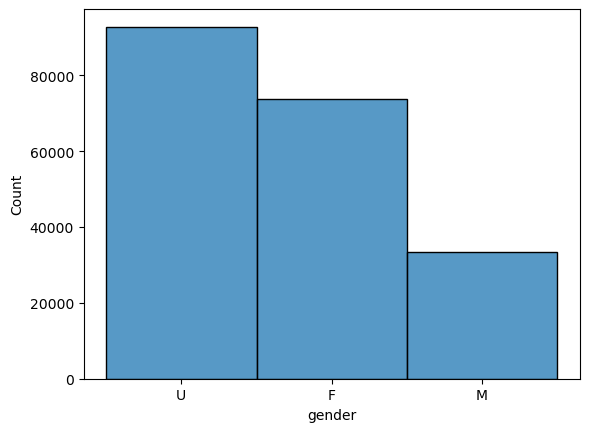

In [19]:
sns.histplot(client['gender'])

In [20]:
client['dif_date'] = (client['first_redeem_date'] - client['first_issue_date']).dt.days

In [21]:
client

,client_id,first_issue_date,first_redeem_date,age,gender,client_id_dec,dif_date
0,000012768d,2017-08-05 15:40:48,2018-01-04 19:30:07,45,U,1209997,152.0
1,000036f903,2017-04-10 13:54:23,2017-04-23 12:37:56,72,F,3602691,12.0
2,00010925a5,2018-07-24 16:21:29,2018-09-14 16:12:49,83,U,17376677,51.0
3,0001f552b0,2017-06-30 19:20:38,2018-08-28 12:59:45,33,F,32854704,423.0
4,00020e7b18,2017-11-27 11:41:45,2018-01-10 17:50:05,73,U,34503448,44.0
...,...,...,...,...,...,...,...
200034,fffe0abb97,2017-11-27 08:56:54,2018-02-11 09:26:08,35,F,1099478776727,76.0
200035,fffe0ed719,2017-09-15 08:53:24,2017-12-12 14:50:12,69,U,1099479045913,88.0
200036,fffea1204c,2018-01-31 16:59:37,2018-03-12 17:02:27,73,F,1099488632908,40.0
200037,fffeca6d22,2017-12-28 11:56:13,NaT,77,F,1099491339554,NaN


### Products

In [22]:
products.head()

,product_id,level_1,level_2,level_3,level_4,segment_id,brand_id,vendor_id,netto,is_own_trademark,is_alcohol
0,0003020d3c,c3d3a8e8c6,c2a3ea8d5e,b7cda0ec0c,6376f2a852,123.0,394a54a7c1,9eaff48661,0.400,0,0
1,0003870676,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,acd3dd483f,10486c3cf0,0.680,0,0
2,0003ceaf69,c3d3a8e8c6,f2333c90fb,419bc5b424,f6148afbc0,271.0,f597581079,764e660dda,0.500,0,0
3,000701e093,ec62ce61e3,4202626fcb,88a515c084,48cf3d488f,172.0,54a90fe769,03c2d70bad,0.112,0,0
4,0007149564,e344ab2e71,52f13dac0c,d3cfe81323,6dc544533f,105.0,63417fe1f3,f329130198,0.600,0,0


In [23]:
for i in ['segment_id', 'brand_id', 'vendor_id']:
    print(i, products[i].nunique())

segment_id 116
brand_id 4296
vendor_id 3193


In [24]:
level_1 = products['level_1'].nunique()
level_2 = products['level_2'].nunique()
level_3 = products['level_3'].nunique()
level_4 = products['level_4'].nunique()

print(f'level_1: {level_1}\nlevel_2: {level_2}\nlevel_3: {level_3}\nlevel_4: {level_4}')


level_1: 3
level_2: 42
level_3: 201
level_4: 790


In [25]:
for i in products['level_1'].unique():
    print(i, ':')
    print('level_2:', products[products['level_1'] == i]['level_2'].nunique())
    print('level_3:', products[products['level_1'] == i]['level_3'].nunique())
    print('level_4:', products[products['level_1'] == i]['level_4'].nunique())

c3d3a8e8c6 :
level_2: 12
level_3: 47
level_4: 201
e344ab2e71 :
level_2: 11
level_3: 85
level_4: 356
ec62ce61e3 :
level_2: 19
level_3: 69
level_4: 233
nan :
level_2: 0
level_3: 0
level_4: 0


Судя по всему левелы - группы товаров, например 1 уровень - продукты питания, на 2 - бакалея, овощи, фрукты и т.д

In [26]:
products[products['is_alcohol']==1]['level_4'].nunique()

38

Группа товаров алгоколя левелы 1 и 2 относится к одному левелу, что подтверждает нашу теорию.

In [27]:
products[products['is_own_trademark'] == 1]['level_2'].nunique()


22

In [28]:
for i in products['segment_id'].unique():
    print(i, ':')
    print('level_1:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_2:', products[products['segment_id'] == i]['level_2'].nunique())
    print('level_3:', products[products['segment_id'] == i]['level_3'].nunique())
    print('level_4:', products[products['segment_id'] == i]['level_4'].nunique())

123.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
105.0 :
level_1: 3
level_2: 3
level_3: 7
level_4: 11
271.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 10
172.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 14
165.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
212.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
48.0 :
level_1: 2
level_2: 2
level_3: 2
level_4: 8
177.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 5
116.0 :
level_1: 1
level_2: 1
level_3: 2
level_4: 9
321.0 :
level_1: 1
level_2: 1
level_3: 4
level_4: 9
150.0 :
level_1: 3
level_2: 3
level_3: 4
level_4: 7
102.0 :
level_1: 2
level_2: 2
level_3: 7
level_4: 12
85.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 4
119.0 :
level_1: 1
level_2: 1
level_3: 3
level_4: 7
111.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 13
92.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 7
214.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 2
223.0 :
level_1: 1
level_2: 1
level_3: 1
level_4: 1
148.0 :
level_1: 2
level_2: 2
level_3: 10
level_4: 35
230.0 :


Оставим значимые признаки, которые все являются категориальными и закодируем их ванхотингом

In [29]:
#list for feature encoding products
list_feat_prod = ['level_1', 'level_2', 'level_3', 'level_4', 'segment_id', 'is_own_trademark'] 

In [30]:
class client_products():
    def __init__(self, data, data_prod, list_feat_prod, n_components = 100):
        self.data = data
        self.data_prod = data_prod
        self.list_feat_prod = list_feat_prod
        self.n_components = n_components
        
    def one_hot(self):
        #Prepare products for one-hot encoding
        x = self.data_prod[self.list_feat_prod]
        x = x.to_numpy()
        x = x.reshape((-1, len(self.list_feat_prod)))
        
        #one hot encoding
        result_one = OneHotEncoder().fit_transform(x)
        return result_one.toarray()
    
    def PCA(self, x):
        pca = PCA(n_components=self.n_components)
        result_pca = pca.fit_transform(x)
        
        #transform to dataframe
        result_pca = pd.DataFrame(result_pca)
        result_pca['product_id'] = self.data_prod['product_id']
        return result_pca
        
    def prod_merge_client(self, x):
        result_prod = self.data[['client_id', 'product_id', 'product_quantity']].merge(x, how='left', on='product_id')
        
        # vectors * quantity
        s = [i for i in range(self.n_components)]
        result_prod[s] =  pd.DataFrame(np.multiply(result_prod[s].to_numpy(), result_prod['product_quantity'].to_numpy().reshape(-1, 1)))
        
        #  delete unnecessary features
        result_prod.drop(['product_id', 'product_quantity'], axis=1, inplace=True)
        #transofrm names column to str 
        result_prod.columns = [str(i) for i in result_prod.columns.to_list()]
        return result_prod.groupby(by='client_id').sum()
    
    def add_mean_feature(self, x):
        self.data['price'] = np.where(self.data['product_quantity']==0, 0, self.data['trn_sum_from_iss'] / self.data['product_quantity']) 
        col = ['client_id',
               'regular_points_received',
               'express_points_received',
               'regular_points_spent',
               'express_points_spent',
               'purchase_sum',
               'price']
        mean_train = self.data[col].groupby(by='client_id',  as_index=False).mean()
        result_mean = x.merge(mean_train, how='left', on='client_id')
        return result_mean

    def sclaler(self, x):
        result_scaler = MinMaxScaler().fit_transform(x.iloc[:, 1:])
        columns = x.columns.to_list()[1:]
        x[columns] = pd.DataFrame(result_scaler)
        return x


In [31]:
a = client_products(train_purch, products, list_feat_prod)

In [32]:
one = a.one_hot()
one

array([[1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [33]:
pca = a.PCA(one)
pca

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,product_id
0,-0.759673,0.034725,0.242503,0.021811,-0.007295,0.523608,0.689012,-0.063594,-0.013803,0.000076,0.041294,-0.139563,-0.005216,-0.001777,-0.004022,0.043858,-0.075878,0.016385,0.000808,-0.031483,0.003237,0.007065,0.002376,0.009777,-0.000434,0.020440,-0.003363,-0.000239,-0.001356,-0.000764,0.000023,0.006988,0.001145,0.001000,-0.001758,0.014396,-0.012097,-0.001986,-0.023437,-0.004135,0.047510,0.310831,0.048865,-0.010022,0.242299,0.008038,-0.056676,-0.037266,0.057992,0.233574,0.693290,-0.027878,0.154436,-0.023943,0.003436,-0.007287,-0.007643,0.000399,0.000308,-0.021577,0.006561,0.040690,1.353905,0.142202,-0.001160,0.002504,-0.005517,0.047281,-0.020371,-0.045031,-0.002613,0.003483,0.006024,-0.001612,-0.011267,-0.009395,-0.004365,0.022304,0.105316,0.208387,0.115650,-0.001926,0.004244,0.001177,0.007569,-0.021056,-0.007422,-0.025593,-0.016261,-0.115441,-0.004417,-0.000369,0.002339,0.001415,-0.011627,0.017245,-0.028066,-0.000267,-0.062615,-0.050234,0003020d3c
1,1.081199,0.762228,0.169956,-0.508035,0.009162,0.003041,0.001003,-0.008582,-0.011257,0.477220,-0.025426,0.001988,0.156711,1.206612,-0.050674,0.053395,-0.025545,-0.071187,-0.008994,0.000916,-0.000551,-0.001865,0.009808,0.005949,-0.000231,0.009089,-0.001939,-0.005905,-0.084226,0.037357,0.002452,-0.048242,-0.006650,-0.000132,0.010790,0.008176,-0.001847,-0.002129,0.001441,0.000178,-0.001704,-0.005198,-0.000279,-0.000753,0.000568,0.000400,-0.003604,-0.000472,-0.000395,0.001148,0.001682,-0.000164,-0.010385,-0.001185,0.001281,-0.007564,-0.004870,0.000724,0.000442,0.003301,-0.000381,0.000592,0.003188,-0.030168,-0.000725,0.000094,0.000179,0.000294,0.002593,0.000491,-0.001264,-0.003513,-0.000141,-0.000152,0.000339,0.000206,0.002388,-0.001036,-0.002652,-0.001097,-0.001686,0.000494,0.000560,-0.000267,0.000519,-0.001520,-0.001408,0.000151,-0.000072,-0.000580,0.000547,-0.001587,0.000496,-0.000546,-0.000038,0.003921,-0.006569,0.002925,-0.001318,-0.004407,0003870676
2,-0.964947,0.086053,1.243832,0.239105,-0.638624,-0.723462,-0.192879,0.015712,0.002372,-0.000507,0.003247,-0.067976,-0.012180,0.000276,0.006216,0.087052,-0.217719,0.110524,0.089088,-0.013452,-0.372989,0.250336,0.159196,-0.006841,-0.000377,0.038266,-0.005726,-0.000149,-0.012921,0.006466,-0.392831,0.002871,0.000352,-0.000065,0.000729,-0.001004,0.000626,0.000105,0.000155,-0.000077,-0.001219,-0.008066,-0.001208,0.000433,0.002291,0.000290,-0.000444,0.000736,-0.000456,-0.001399,0.001856,-0.000372,-0.005151,-0.006150,0.002532,-0.007972,-0.007836,0.000746,-0.000080,0.005815,-0.000626,0.000564,0.002188,-0.001567,0.668696,-0.011461,0.004144,-0.012223,0.085214,-0.022233,-0.012913,0.001328,-0.000281,0.000068,0.000001,-0.000172,0.000461,-0.000208,0.001721,-0.000631,0.000148,0.000056,-0.002105,0.031952,0.001927,-0.001382,0.000884,0.000026,0.000014,-0.001019,-0.000094,-0.000439,-0.002790,0.000630,-0.000186,-0.006686,-0.000961,0.003781,0.011164,-0.052496,0003ceaf69
3,-0.181096,-0.625480,0.277458,-0.257173,1.209219,-0.263426,-0.073677,0.036352,0.015106,0.022266,-0.022075,-0.026189,-0.081295,-0.009079,0.073479,-0.559326,-0.723079,-0.920705,-0.113243,0.012579,-0.000485,-0.001242,0.172146,-0.099260,-0.004318,-0.128634,0.018501,0.024097,0.414908,-0.237326,-0.018979,-0.387223,-0.054121,-0.001293,0.019334,-0.006247,0.185017,0.238480,0.005599,0.003905,-0.025779,-0.022010,0.253224,-0.361727,-0.001529,-0.014315,0.122945,0.018056,-0.057265,0.024760,0.016655,-0.000408,-0.049278,0.011889,-0.004033,0.006284,-0.000170,-0.000084,-0.003901,-0.022941,0.000501,-0.000452,0.000249,-0.002221,-0.000216,-0.000781,-0.000610,0.000157,0.000067,0.001744,-0.000191,-0.003931,0.000707,0.005297,-0.002774,0.000605,0.003149,-0.001337,-0.000926,0.008070,-0.004463,0.001096,-0.000836,0.00391

In [34]:
prod_merge_client = a.prod_merge_client(pca)
prod_merge_client

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
client_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000012768d,-9.988463,-0.319658,-17.259623,1.989308,-4.848703,-2.410757,1.012451,-5.033635,-8.178356,-1.650480,-3.228077,-0.107604,-5.427307,1.641983,0.579506,0.574316,-1.453248,1.034152,-2.332786,-2.163650,0.779054,1.358253,-0.250667,0.399750,-4.088112,-0.123692,-1.693063,2.752971,-0.485330,1.805997,0.042477,-1.166397,1.184946,2.946431,1.665489,-1.741379,0.102648,-0.070183,0.306550,-2.168651,-1.298258,1.767550,0.086781,-0.095902,-1.035869,-0.892943,-0.491015,0.604127,-0.238281,0.588280,-1.514595,-0.686453,-0.416226,-0.844807,0.438228,0.040206,4.376760,2.315730,0.137918,0.223363,-0.787162,1.503727,-0.082968,-0.377795,0.076977,-1.794187,-1.519574,-0.130642,-0.739253,-0.868884,-0.066604,-0.697209,-1.530223,-0.105513,-0.485775,-0.031307,-0.339889,-0.113822,0.156639,-0.116446,-0.066056,4.095102,1.197733,0.042588,-1.351574,-1.179161,0.057667,-0.117048,0.796635,-0.181973,0.110491,0.121909,1.904348,0.299408,2.994719,1.394470,-0.240197,-0.362718,1.181055,-0.313691
000036f903,-22.285992,20.241624,-14.487000,29.736863,-2.739127,6.232977,7.199560,-5.914535,-2.090337,0.944201,-4.833652,1.220311,-13.569374,-2.932824,5.936956,-6.315017,15.372091,-6.011771,-3.186839,-0.778573,3.861524,6.223642,4.531441,1.983735,-9.491147,4.387189,-0.723261,-0.094345,-7.313332,1.262847,2.199574,-3.664704,-4.708986,0.452333,7.178744,-2.902773,-0.902596,-0.175814,-0.147233,-1.233630,2.745579,23.442516,2.953660,-0.355456,-8.183916,-2.050749,0.052849,-2.613014,0.246388,10.354506,-1.985594,-0.326053,-0.829204,3.471933,2.347736,-8.483694,33.469298,1.998564,0.605701,0.836989,-3.403545,-3.139861,-1.277087,0.139583,-1.785636,-5.177956,1.002274,-1.152642,16.436219,13.919326,3.128421,14.413555,-3.572428,1.932008,-5.687735,1.195363,-0.624343,-1.516656,-3.731747,-8.261370,-4.606157,4.539779,0.753620,-0.158429,7.671695,4.956642,-0.158466,-1.011898,0.918435,-2.031091,-0.621322,-0.861199,-3.142849,-0.339072,-1.055263,-1.455700,-1.699124,2.294640,-4.728459,1.044501
0001f552b0,23.596421,-27.536659,-10.964846,-1.703126,-15.832587,4.563244,-0.184472,-7.726079,-11.543811,-2.026518,1.551334,4.460047,-1.867720,2.704403,5.078952,-0.951105,2.419671,-0.066417,2.696921,1.167832,2.027018,2.483752,-1.411103,-0.712462,0.366657,0.760633,0.804930,-1.834634,5.485948,-2.083629,-0.171669,6.911794,0.923303,0.059793,8.101930,5.412025,-10.484672,7.016859,1.356926,-4.955026,3.357086,4.797905,0.696636,3.597376,0.465310,-4.421392,33.265429,9.533220,48.578917,1.199493,-1.008572,0.085248,-5.183593,-8.247906,1.238894,0.074798,8.817520,-0.188157,1.844644,-0.263289,1.893386,-0.910001,0.421748,-0.821155,-0.309167,-1.342173,-0.205152,-0.464122,0.808657,-1.819725,-2.669617,-1.986519,-1.965579,2.655894,-0.371468,0.256307,-3.903436,2.385649,-1.822927,0.721444,0.947958,0.110230,-0.342129,-0.352654,0.647747,-0.649797,-0.127623,-0.033601,2.184115,-0.680458,1.287737,-1.504706,3.461414,-0.408946,-4.398335,-1.173848,0.158545,-0.349636,-0.470128,-0.195581
00020e7b18,-104.153751,33.366153,-79.329473,-9.613373,-46.714891,-33.796296,-8.713225,-3.328249,-19.767105,22.461969,-4.628765,26.428852,-17.989080,6.255679,57.575869,3.138557,-3.843463,10.859549,-17.587033,0.706055,-4.128457,17.817510,3.793659,25.881828,-39.440389,0.168988,-0.844133,7.416764,5.145908,-1.143373,-5.734420,1.461959,5.536573,54.880682,-10.172353,0.828293,1.863196,-2.083389,-3.359012,-4.150778,-0.258415,14.605955,1.484144,1.852942,-6.566636,0.920451,5.784709,-3.022561,-6.727650,9.035949,-3.041388,8.540407,-6.927480,-5.446576,6.852658,-6.427817,29.547615,6.896905,0.893532,0.692993,-4.256469,3.865046,-2.837142,-6.128306,9.531205,2.602209,-3.451223,-2.401745,-1.4

In [35]:
res = a.add_mean_feature(prod_merge_client)
res

/tmp/ipykernel_1841/3127285308.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_mean = x.merge(mean_train, how='left', on='client_id')


,client_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price
0,000012768d,-9.988463,-0.319658,-17.259623,1.989308,-4.848703,-2.410757,1.012451,-5.033635,-8.178356,-1.650480,-3.228077,-0.107604,-5.427307,1.641983,0.579506,0.574316,-1.453248,1.034152,-2.332786,-2.163650,0.779054,1.358253,-0.250667,0.399750,-4.088112,-0.123692,-1.693063,2.752971,-0.485330,1.805997,0.042477,-1.166397,1.184946,2.946431,1.665489,-1.741379,0.102648,-0.070183,0.306550,-2.168651,-1.298258,1.767550,0.086781,-0.095902,-1.035869,-0.892943,-0.491015,0.604127,-0.238281,0.588280,-1.514595,-0.686453,-0.416226,-0.844807,0.438228,0.040206,4.376760,2.315730,0.137918,0.223363,-0.787162,1.503727,-0.082968,-0.377795,0.076977,-1.794187,-1.519574,-0.130642,-0.739253,-0.868884,-0.066604,-0.697209,-1.530223,-0.105513,-0.485775,-0.031307,-0.339889,-0.113822,0.156639,-0.116446,-0.066056,4.095102,1.197733,0.042588,-1.351574,-1.179161,0.057667,-0.117048,0.796635,-0.181973,0.110491,0.121909,1.904348,0.299408,2.994719,1.394470,-0.240197,-0.362718,1.181055,-0.313691,7.551923,0.000000,0.000000,0.000000,784.788462,46.403846
1,000036f903,-22.285992,20.241624,-14.487000,29.736863,-2.739127,6.232977,7.199560,-5.914535,-2.090337,0.944201,-4.833652,1.220311,-13.569374,-2.932824,5.936956,-6.315017,15.372091,-6.011771,-3.186839,-0.778573,3.861524,6.223642,4.531441,1.983735,-9.491147,4.387189,-0.723261,-0.094345,-7.313332,1.262847,2.199574,-3.664704,-4.708986,0.452333,7.178744,-2.902773,-0.902596,-0.175814,-0.147233,-1.233630,2.745579,23.442516,2.953660,-0.355456,-8.183916,-2.050749,0.052849,-2.613014,0.246388,10.354506,-1.985594,-0.326053,-0.829204,3.471933,2.347736,-8.483694,33.469298,1.998564,0.605701,0.836989,-3.403545,-3.139861,-1.277087,0.139583,-1.785636,-5.177956,1.002274,-1.152642,16.436219,13.919326,3.128421,14.413555,-3.572428,1.932008,-5.687735,1.195363,-0.624343,-1.516656,-3.731747,-8.261370,-4.606157,4.539779,0.753620,-0.158429,7.671695,4.956642,-0.158466,-1.011898,0.918435,-2.031091,-0.621322,-0.861199,-3.142849,-0.339072,-1.055263,-1.455700,-1.699124,2.294640,-4.728459,1.044501,2.150000,2.222222,0.000000,0.000000,362.746914,50.374486
2,0001f552b0,23.596421,-27.536659,-10.964846,-1.703126,-15.832587,4.563244,-0.184472,-7.726079,-11.543811,-2.026518,1.551334,4.460047,-1.867720,2.704403,5.078952,-0.951105,2.419671,-0.066417,2.696921,1.167832,2.027018,2.483752,-1.411103,-0.712462,0.366657,0.760633,0.804930,-1.834634,5.485948,-2.083629,-0.171669,6.911794,0.923303,0.059793,8.101930,5.412025,-10.484672,7.016859,1.356926,-4.955026,3.357086,4.797905,0.696636,3.597376,0.465310,-4.421392,33.265429,9.533220,48.578917,1.199493,-1.008572,0.085248,-5.183593,-8.247906,1.238894,0.074798,8.817520,-0.188157,1.844644,-0.263289,1.893386,-0.910001,0.421748,-0.821155,-0.309167,-1.342173,-0.205152,-0.464122,0.808657,-1.819725,-2.669617,-1.986519,-1.965579,2.655894,-0.371468,0.256307,-3.903436,2.385649,-1.822927,0.721444,0.947958,0.110230,-0.342129,-0.352654,0.647747,-0.649797,-0.127623,-0.033601,2.184115,-0.680458,1.287737,-1.504706,3.461414,-0.408946,-4.398335,-1.173848,0.158545,-0.349636,-0.470128,-0.195581,6.420930,0.000000,0.000000,0.000000,557.841163,60.972481
3,00020e7b18,-104.153751,33.366153,-79.329473,-9.613373,-46.714891,-33.796296,-8.713225,-3.328249,-19.767105,22.461969,-4.628765,26.428852,-17.989080,6.255679,57.575869,3.138557,-3.843463,10.859549,-17.587033,0.706055,-4.128457,17.817510,3.793659,25.881828,-39.440389,0.168988,-0.844133,7.416764,5.145908,-1.143373,-5.734420,1.461959,5.536573,54.880682,-10.172353,0.828293,1.863196,-2.083389,-3.359012,-4.150778,-0.258415,14.605955,1.484144,1.852942,-6.566636,0.920451,5.784709,-3.022561,-6.7276

In [36]:
res_scaler_train = a.sclaler(res)
res_scaler_train

,client_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price
0,000012768d,0.298621,0.432653,0.831460,0.846764,0.626652,0.607852,0.328089,0.585355,0.644966,0.943607,0.615663,0.378971,0.934423,0.340407,0.107427,0.848198,0.082130,0.383033,0.631728,0.420186,0.619999,0.362831,0.763154,0.088372,0.540226,0.702295,0.377367,0.763065,0.527742,0.512534,0.072491,0.321644,0.187287,0.741657,0.405136,0.367144,0.413675,0.253818,0.308366,0.141558,0.226853,0.209870,0.378910,0.319895,0.664233,0.894215,0.062195,0.648705,0.061317,0.217080,0.825385,0.121558,0.305134,0.688264,0.207439,0.639315,0.222933,0.605147,0.336103,0.199491,0.366304,0.757588,0.469299,0.648246,0.260076,0.881045,0.725893,0.394369,0.794322,0.767436,0.376451,0.199453,0.817501,0.236521,0.231579,0.354306,0.618800,0.626858,0.584455,0.717223,0.422948,0.368347,0.667890,0.437209,0.074988,0.147238,0.521942,0.701412,0.483957,0.390444,0.662423,0.399843,0.400412,0.737512,0.734977,0.447598,0.684222,0.279474,0.596315,0.674700,0.038887,0.00000,1.000000,1.000000,0.097023,0.044936
1,000036f903,0.294312,0.437322,0.832806,0.856812,0.627715,0.618506,0.344688,0.584540,0.647482,0.944316,0.615060,0.381268,0.930893,0.335029,0.109448,0.834944,0.101257,0.377331,0.630428,0.423798,0.622410,0.366767,0.767697,0.089619,0.527946,0.713178,0.378850,0.760840,0.521336,0.511789,0.075028,0.319721,0.181681,0.738845,0.415855,0.365283,0.412586,0.253706,0.307594,0.142023,0.230081,0.247768,0.390044,0.319261,0.640194,0.891620,0.062520,0.645114,0.061499,0.231805,0.824089,0.121758,0.304715,0.696769,0.216090,0.620140,0.247496,0.604974,0.337795,0.201147,0.354102,0.752903,0.460112,0.649555,0.246632,0.879488,0.730396,0.391056,0.823791,0.789939,0.389342,0.225352,0.816095,0.242353,0.215923,0.366021,0.618183,0.624867,0.573989,0.696879,0.412876,0.369845,0.666625,0.434613,0.088981,0.159721,0.520899,0.695666,0.484092,0.376215,0.657202,0.396160,0.395183,0.733235,0.730050,0.431093,0.678477,0.288772,0.574425,0.680844,0.011071,0.01713,1.000000,1.000000,0.044777,0.048781
2,0001f552b0,0.310389,0.426473,0.834515,0.845426,0.621119,0.616448,0.324878,0.582864,0.643575,0.943504,0.617455,0.386872,0.935966,0.341656,0.109124,0.845263,0.086533,0.382142,0.639384,0.428874,0.620975,0.363741,0.762051,0.087496,0.550350,0.704428,0.381188,0.759480,0.533345,0.507199,0.072239,0.327860,0.187038,0.738402,0.417650,0.378609,0.402205,0.261313,0.310153,0.140171,0.230569,0.215168,0.381278,0.328907,0.669281,0.886307,0.082334,0.658674,0.079709,0.218001,0.826777,0.121986,0.300303,0.673679,0.211066,0.639393,0.226683,0.603782,0.342277,0.198177,0.378804,0.755153,0.473182,0.647125,0.257289,0.881253,0.728240,0.393288,0.796978,0.765989,0.365948,0.197243,0.817201,0.244425,0.231923,0.357053,0.611065,0.630406,0.579127,0.719316,0.425198,0.354916,0.663503,0.432104,0.078088,0.148315,0.521048,0.701948,0.485491,0.386608,0.670822,0.393749,0.402026,0.732767,0.725984,0.432725,0.685792,0.279520,0.590199,0.675235,0.033063,0.00000,1.000000,1.000000,0.068928,0.059044
3,00020e7b18,0.265627,0.440302,0.801341,0.842562,0.605562,0.569167,0.301997,0.586933,0.640177,0.950202,0.615137,0.424869,0.928977,0.345832,0.128930,0.853131,0.079413,0.390984,0.608508,0.427669,0.616162,0.376146,0.766996,0.108431,0.459881,0.703001,0.378665,0.766710,0.533026,0.508489,0.065697,0.323666,0.191426,0.800228,0.382120,0.371263,0.415582,0.251689,0.302128,0.140571,0.227683,0.232318,0.384337,0.324650,0.645633,0.898279,0.065939,0.644656,0.058872,0.229817,0.821184,0.126673,0.298535,0.679198,0.236499,0.624765,0.244185,0.607643,0.338836,0.200758,0.350125,0.759970,0.448110,0.633701,0.328317,0.883067,0.722443,0.387008,0.793105,0.765469,0.380463,0.195559,0.816565,0.254178,0.237587,0.33

In [37]:
res_scaler_train.to_csv('client_train.csv', index=False)

In [38]:
b = client_products(test_purch, products, list_feat_prod)

In [39]:
one = b.one_hot()
pca = b.PCA(one)
prod_merge_client = b.prod_merge_client(pca)
res = b.add_mean_feature(prod_merge_client)
res_scaler_test = b.sclaler(res)
res_scaler_test


/tmp/ipykernel_1841/3127285308.py:50: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  result_mean = x.merge(mean_train, how='left', on='client_id')


,client_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,regular_points_received,express_points_received,regular_points_spent,express_points_spent,purchase_sum,price
0,00010925a5,0.602796,0.653504,0.561760,0.812171,0.947037,0.095243,0.178090,0.907668,0.264658,0.926361,0.439495,0.208683,0.664949,0.422082,0.468137,0.920007,0.034176,0.951303,0.903037,0.135107,0.956343,0.661192,0.816497,0.161478,0.422567,0.890799,0.306665,0.560601,0.548010,0.546541,0.161521,0.205397,0.521568,0.343602,0.414817,0.215596,0.914976,0.066729,0.085698,0.493134,0.488615,0.445288,0.444201,0.289313,0.769974,0.731379,0.091359,0.176578,0.037361,0.102117,0.880404,0.269405,0.637292,0.922629,0.273830,0.310247,0.217640,0.343389,0.120849,0.512366,0.641548,0.414116,0.684596,0.635685,0.608016,0.606975,0.591011,0.357937,0.416601,0.423449,0.523367,0.397089,0.379295,0.352998,0.337475,0.580518,0.417323,0.395243,0.695286,0.761572,0.340305,0.291263,0.339384,0.339985,0.573275,0.050812,0.262911,0.182152,0.222712,0.565737,0.689919,0.598949,0.132457,0.286948,0.438395,0.744924,0.769402,0.493480,0.460429,0.406862,0.010441,0.0,0.997957,1.000000,0.046507,0.073531
1,00035a21d9,0.609385,0.652256,0.566319,0.813157,0.949011,0.091118,0.171850,0.907309,0.266069,0.925782,0.441968,0.208642,0.673872,0.422065,0.466685,0.923028,0.031539,0.952599,0.905848,0.131656,0.957005,0.660531,0.817323,0.160063,0.433946,0.889121,0.314986,0.556071,0.547499,0.547101,0.159567,0.207583,0.523016,0.312947,0.415671,0.214911,0.912496,0.069168,0.088981,0.501211,0.484730,0.435897,0.432972,0.288529,0.777933,0.733028,0.091229,0.166528,0.037163,0.096040,0.885792,0.264884,0.634800,0.916414,0.272003,0.320833,0.204877,0.335709,0.118983,0.499193,0.648864,0.419167,0.691918,0.647368,0.607558,0.609749,0.597552,0.358919,0.425262,0.429506,0.529326,0.402749,0.382069,0.354683,0.337606,0.586296,0.415120,0.397320,0.689168,0.764287,0.341671,0.303604,0.337262,0.341459,0.571460,0.051087,0.266278,0.175649,0.217438,0.564584,0.690977,0.601367,0.129879,0.281872,0.435870,0.748938,0.782112,0.495120,0.464713,0.411372,0.049810,0.0,0.992501,0.727778,0.086052,0.064047
2,00038f9200,0.600764,0.657300,0.553440,0.803758,0.943214,0.090692,0.176712,0.905878,0.261282,0.914009,0.438115,0.266046,0.664378,0.420195,0.470577,0.919291,0.034807,0.945542,0.917558,0.124489,0.956237,0.660755,0.815346,0.162727,0.443638,0.884479,0.268089,0.563394,0.547880,0.546076,0.156120,0.199799,0.533277,0.295375,0.414326,0.214943,0.913536,0.069313,0.088700,0.507227,0.488368,0.442789,0.437541,0.297278,0.780018,0.613522,0.090001,0.173158,0.036982,0.100395,0.881872,0.284909,0.638106,0.916388,0.278581,0.315095,0.215665,0.338673,0.119921,0.501135,0.658723,0.413655,0.687775,0.633341,0.623597,0.599583,0.588619,0.355786,0.417962,0.419363,0.544178,0.397159,0.374952,0.346642,0.324811,0.568115,0.414681,0.397892,0.696372,0.756026,0.339132,0.303958,0.337551,0.344893,0.567925,0.051685,0.268354,0.173005,0.224243,0.561729,0.688771,0.602205,0.134892,0.283344,0.422091,0.743389,0.772466,0.492488,0.473524,0.410519,0.011122,0.0,0.998968,1.000000,0.030306,0.047990
3,0004315e57,0.612397,0.643062,0.558015,0.811745,0.937913,0.092780,0.174199,0.904878,0.262935,0.924205,0.444903,0.213480,0.665238,0.425045,0.481242,0.921109,0.032936,0.952624,0.905793,0.134739,0.958228,0.663436,0.817166,0.162735,0.425436,0.890706,0.318394,0.547477,0.550508,0.545758,0.160164,0.204901,0.529165,0.323361,0.420834,0.210654,0.911896,0.071205,0.089253,0.493191,0.485256,0.443547,0.437992,0.298302,0.772681,0.729431,0.094024,0.172750,0.035625,0.101175,0.881206,0.288759,0.636048,0.918983,0.273155,0.319288,0.215249,0.360009,0.120261,0.489194,0.660610,0.458849,0.677833,0.637810,0.608815,0.611853,0.597100,0.351795,0.423858,0.421632,0.527901,0.398380,0.377765,0.374669,0.332799,0.564053,0.41978

In [40]:
res_scaler_test.to_csv('client_test.csv', index=False)